In [1]:
# Install dependencies

!pip install -q transformers==4.28.0 datasets gdown accelerate rouge_score keras_nlp Pillow matplotlib scikit-learn kaggle


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Connect kaggle and download dataset

# import json

# data = {"username": "adirizq", "key": "12b93755f4cdefe1c5fb0de9dfd288fb"}
# with open('kaggle.json', 'w') as f:
#     json.dump(data, f)

# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv ./kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d adirizq/shopee-product-images
# !mkdir datasets
# !unzip -q shopee-product-images.zip -d datasets
# !rm shopee-product-images.zip

In [3]:
# Import dependencies

import pandas as pd
import urllib.request
import io
import os
import sys
import requests
import PIL
import datasets
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import keras_nlp


from PIL import Image
from datasets import Dataset, load_dataset, load_from_disk, DatasetDict, load_metric
from transformers import TFVisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, DefaultDataCollator
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split

2023-06-02 09:57:09.276215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Set root folder

img_root_folder = 'datasets/images/download'
text_root_folder = 'datasets'

In [5]:
# Load data

products = pd.read_csv(f'{text_root_folder}/data_products_id_small.csv')
products

,product_id,image,name,shop_name,shopid,main_category,sub_category
0,12523520280,e6205d4fcb8a485235778ad210ac4d90,PS3 Super Slim 1TB Full Game + 2 Stik getar + ...,spirit elektronik,379815570,Elektronik,Konsol Game
1,17941082335,8563c9fc31b880ed105f91b8d43e6d88,GAMEBOY PVP DUAL ANALOG FULLSET BISA MAIN DI T...,Gaming Console Store,268909000,Elektronik,Konsol Game
2,23517487660,id-11134207-7qul7-leyb85rn449s74,Pulsa Min A10 K1T Remote,GAMOLBERKAH,102394348,Elektronik,Konsol Game
3,7978948479,d6b77df3df58d6a13b3d78eeb303cbb5,DUS PSP-2004/ DUS PSP STREET E1004,GAMES168,28318233,Elektronik,Konsol Game
4,4653307963,f888e78a3845120009602a0b23e65ce0,playstation 2 full game|| hardis external full...,Milkha_shop,293187724,Elektronik,Konsol Game
...,...,...,...,...,...,...,...
162200,3018504943,5ceeaa7f35f1e56198e592d6678fcd29,Casing Pelindung Kamera Slr Nikon D600 D610 D6...,wuqingqing,250204553,Fotografi,Tas & Casing Kamera
162201,23816257709,id-11134201-23020-5gt7a9rapunv5a,Instax Case Mini 40,Fujifilm Official Shop,63784624,Fotografi,Tas & Casing Kamera
162202,17891926693,id-11134201-23020-ry891wp0ounv82,Instax Retro Case Mini Evo Landscape,Fujifilm Official Shop,63784624,Fotografi,Tas & Casing Kamera
162203,21669977732,sg-11134201-22120-4umc9s04lmlve0,Tas tripod / Tas lightstand Murah,Konveksi_tas_almuja03,327928791,Fotografi,Tas & Casing Kamera


In [6]:
# Data preparation

products["img_path"] = products.apply(lambda x: f'{img_root_folder}/{x["main_category"]}/{x["sub_category"]}/{x["image"]}_tn-{x["product_id"]}.jpeg', axis=1)
products["img_class"] = products["main_category"]
products["img_title"] = products["name"]
products = products.drop(["product_id", "image", "name", "shop_name", "shopid", "main_category"], axis=1)
products

,sub_category,img_path,img_class,img_title
0,Konsol Game,datasets/images/download/Elektronik/Konsol Gam...,Elektronik,PS3 Super Slim 1TB Full Game + 2 Stik getar + ...
1,Konsol Game,datasets/images/download/Elektronik/Konsol Gam...,Elektronik,GAMEBOY PVP DUAL ANALOG FULLSET BISA MAIN DI T...
2,Konsol Game,datasets/images/download/Elektronik/Konsol Gam...,Elektronik,Pulsa Min A10 K1T Remote
3,Konsol Game,datasets/images/download/Elektronik/Konsol Gam...,Elektronik,DUS PSP-2004/ DUS PSP STREET E1004
4,Konsol Game,datasets/images/download/Elektronik/Konsol Gam...,Elektronik,playstation 2 full game|| hardis external full...
...,...,...,...,...
162200,Tas & Casing Kamera,datasets/images/download/Fotografi/Tas & Casin...,Fotografi,Casing Pelindung Kamera Slr Nikon D600 D610 D6...
162201,Tas & Casing Kamera,datasets/images/download/Fotografi/Tas & Casin...,Fotografi,Instax Case Mini 40
162202,Tas & Casing Kamera,datasets/images/download/Fotografi/Tas & Casin...,Fotografi,Instax Retro Case Mini Evo Landscape
162203,Tas & Casing Kamera,datasets/images/download/Fotografi/Tas & Casin...,Fotografi,Tas tripod / Tas lightstand Murah


In [7]:
# Limit data to one main category only

print(products['img_class'].value_counts())
products = products.loc[products['img_class'] == 'Komputer & Aksesoris']
products = products[products.groupby('sub_category')['sub_category'].transform('size') > 1]
products

img_class
Olahraga & Outdoor           13050
Elektronik                   11510
Perawatan & Kecantikan       10479
Pakaian Wanita                9333
Perlengkapan Rumah            8932
Aksesoris Fashion             8912
Pakaian Pria                  7888
Ibu & Bayi                    7474
Komputer & Aksesoris          7365
Kesehatan                     6969
Otomotif                      6843
Hobi & Koleksi                6592
Buku & Alat Tulis             6512
Handphone & Aksesoris         5983
Fashion Bayi & Anak           5940
Tas Wanita                    5926
Sepatu Wanita                 5911
Fashion Muslim                5500
Makanan & Minuman             5498
Sepatu Pria                   4500
Tas Pria                      4189
Jam Tangan                    2491
Souvenir & Party Supplies     2477
Fotografi                     1931
Name: count, dtype: int64


,sub_category,img_path,img_class,img_title
17008,Desktop,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,Kingston HyperX Cloud Earbuds Handsfree Gaming
17009,Desktop,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,PC RAKITAN CORE I5 KOMPUTER KANTOR ADMIN OFFIC...
17010,Desktop,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,02 RDP SOFTWARE SERVER PC RAM MURAH PROSES CEPAT
17011,Desktop,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,NOTA LIVE 1kg 10-60
17012,Desktop,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,NF PREM
...,...,...,...,...
24368,Komputer & Aksesoris Lainnya,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,Adaptor 12V 1A second/bekas
24369,Komputer & Aksesoris Lainnya,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,KABEL HDMI 1.5M V.2.0 ULTRA HD 4K HIGH QUALITY...
24370,Komputer & Aksesoris Lainnya,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,Link berat 1kg 10k-40k
24371,Komputer & Aksesoris Lainnya,datasets/images/download/Komputer & Aksesoris/...,Komputer & Aksesoris,AMAZON PRIME VIDEO PRIVATE 1 BULAN DAN 1 TAHUN...


In [8]:
# Splitting data

train_val_df, test_df = train_test_split(products, test_size=0.05, stratify=products['sub_category'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.05, stratify=train_val_df['sub_category'], random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Total train data:", len(train_df))
print("Total validation data:", len(val_df))
print("Total test data:", len(test_df))

Total train data: 6646
Total validation data: 350
Total test data: 369


/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12304 (\N{LEFT BLACK LENTICULAR BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12305 (\N{RIGHT BLACK LENTICULAR BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


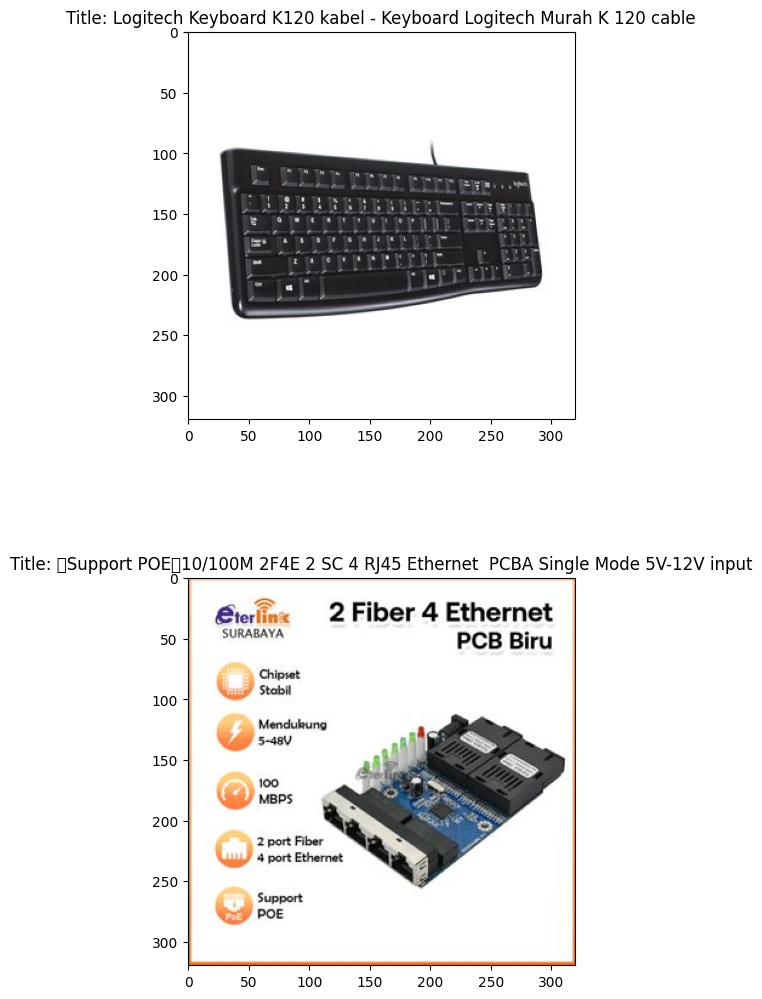

In [9]:
# Check training sample
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(5,13))          
ax = axes.ravel()
for i in range(2):
  peek_data = train_df.iloc[random.randrange(0, len(train_df))]
  ax[i].imshow(mpimg.imread(peek_data.img_path))
  ax[i].title.set_text('Title: ' + str(peek_data.img_title))         
plt.subplots_adjust(hspace=0.2)                                    
plt.show()

In [10]:
# Setup huggingface dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [11]:
# Setup huggingface dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [12]:
# Load pretrained ImageProcessor and pretrained Tokenizer

encoder_pretrained = 'google/vit-base-patch16-224'
decoder_pretrained = 'indolem/indobert-base-uncased'

image_processor = AutoImageProcessor.from_pretrained(encoder_pretrained)
tokenizer = AutoTokenizer.from_pretrained(decoder_pretrained)

In [13]:
# Preprocess function

def preprocess(data):
  image = Image.open(data["img_path"]).convert("RGB")
  pixel_values = image_processor(image, return_tensors="np").pixel_values[0]

  encoded_title = tokenizer(data["img_title"], padding="max_length", max_length=128, truncation=True)
  labels = [lbl if lbl != tokenizer.pad_token_id else -100 for lbl in encoded_title.input_ids]

  return {"pixel_values": pixel_values, "labels": labels}

In [14]:
# Preprocess dataset

train_dataset = train_dataset.map(preprocess, writer_batch_size=1000).remove_columns(["sub_category", "img_path", "img_title", "img_class"])
val_dataset = val_dataset.map(preprocess, writer_batch_size=1000).remove_columns(["sub_category", "img_path", "img_title", "img_class"])
test_dataset = test_dataset.map(preprocess, writer_batch_size=1000).remove_columns(["sub_category", "img_path", "img_title", "img_class"])

Map:   0%|          | 0/6646 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/369 [00:00<?, ? examples/s]

In [15]:
# Convert to tf dataset

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(columns=["pixel_values"],
                                               label_cols=["labels"],
                                               batch_size=24,
                                               collate_fn=data_collator,
                                               shuffle=True)

tf_val_dataset = val_dataset.to_tf_dataset(columns=["pixel_values"],
                                               label_cols=["labels"],
                                               batch_size=24,
                                               collate_fn=data_collator,
                                               shuffle=False)

tf_test_dataset = test_dataset.to_tf_dataset(columns=["pixel_values"],
                                               label_cols=["labels"],
                                               batch_size=24,
                                               collate_fn=data_collator,  
                                               shuffle=False)

/usr/local/lib/python3.8/dist-packages/datasets/arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
2023-06-02 09:58:07.958086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21659 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


In [16]:
# RougeL metrics

rouge_l = keras_nlp.metrics.RougeL()

def metric_fn(predictions, labels):
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    for label in labels:
        label[label == -100] = tokenizer.pad_token_id 
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge_l(decoded_labels, decoded_predictions)
    
    result = {"RougeL": result["f1_score"]}

    return result

In [17]:
# Setup VisionEncoderDecoder model from pretrained encoder(ViT) and pretrained decoder(IndoBERT)

model = TFVisionEncoderDecoderModel.from_encoder_decoder_pretrained(encoder_pretrained, decoder_pretrained, decoder_from_pt=True)

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

2023-06-02 09:58:11.523704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-02 09:58:12.326825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at google/vit-base-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newl

In [18]:
# Training model

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=3,
    mode="min",
    restore_best_weights=True,
    start_from_epoch=0,
)

model.fit(
    tf_train_dataset, validation_data=tf_val_dataset, epochs=10, callbacks=[early_stop]
)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10


2023-06-02 09:58:14.995247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [6646]
	 [[{{node Placeholder/_0}}]]
2023-06-02 09:58:14.995496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [6646]
	 [[{{node Placeholder/_0}}]]
/usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:371: FutureWarning: Version v4.17.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tu

2023-06-02 09:59:19.107698: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0xb7beb030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-02 09:59:19.107756: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-02 09:59:19.417837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-02 09:59:19.571567: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


277/277 [==============================] - ETA: 0s - loss: 6.8920

2023-06-02 10:02:43.923567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [350]
	 [[{{node Placeholder/_0}}]]


277/277 [==============================] - 283s 427ms/step - loss: 6.8920 - val_loss: 5.9295
Epoch 2/10
277/277 [==============================] - 158s 568ms/step - loss: 5.5178 - val_loss: 4.9541
Epoch 3/10
277/277 [==============================] - 155s 556ms/step - loss: 4.8168 - val_loss: 4.4946
Epoch 4/10
277/277 [==============================] - 156s 562ms/step - loss: 4.3692 - val_loss: 4.2287
Epoch 5/10
277/277 [==============================] - 152s 548ms/step - loss: 4.0382 - val_loss: 4.0248
Epoch 6/10
277/277 [==============================] - 155s 559ms/step - loss: 3.7698 - val_loss: 3.8808
Epoch 7/10
277/277 [==============================] - 158s 568ms/step - loss: 3.5326 - val_loss: 3.7505
Epoch 8/10
277/277 [==============================] - 147s 528ms/step - loss: 3.3235 - val_loss: 3.6711
Epoch 9/10
277/277 [==============================] - 154s 556ms/step - loss: 3.1319 - val_loss: 3.6247
Epoch 10/10
277/277 [==============================] - 150s 539ms/step - lo

In [19]:
import shutil

model.save_pretrained('vit_bert_komputer_aksesoris')

shutil.make_archive("vit_bert_komputer_aksesoris", "zip", "vit_bert_komputer_aksesoris")

'/root/vit_bert_komputer_aksesoris.zip'

In [20]:
!rm -r vit_bert_komputer_aksesoris

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:745: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:854: UserWarning: Using `max_length`'s default (128) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


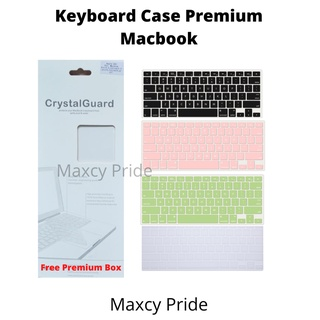

Case Keyboard Bahan Silikon Untuk Macbook Pelindung Keyboard macbook Silicone keyboard protector cover for Macbook Pro / Air M1 M2 Retina
['keyboard protector protector anti gores 14 inch anti air anti air 14 14 14 15 inch id macbook 2021 2020 keyboard laptop cover 13 15 anti slip pro protector 2017 putih arab hitam promo a ( cek 10 sikat desk pelindung komputer 14 mouse 14 inc 14 inchi 14 - 14 include']
RougeL:
tf.Tensor(0.14285715, shape=(), dtype=float32)


In [21]:
# Test inference

testing_data = test_df.iloc[random.randrange(0, len(test_df))]

image = Image.open(testing_data["img_path"]).convert("RGB")
title = testing_data["img_title"]

pixel_values = image_processor(image, return_tensors="tf").pixel_values
labels = tokenizer(title, return_tensors="tf").input_ids

generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

image.show()
print(title)
print(generated_text)
print("RougeL:")
print(rouge_l([title], generated_text)["f1_score"])

In [22]:
!rm -r ~/.local/share/Trash

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
